In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload
from scipy.sparse.linalg import cg

In [2]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)
nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


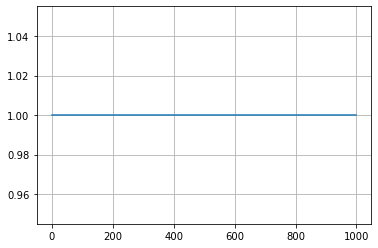

In [3]:
pix_size = 10 #arcmin
ell = np.arange(0, 1000)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:9: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))


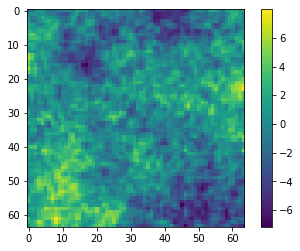

In [4]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
plt.imshow(m)
plt.colorbar()

In [5]:
reload(lib)
D, D_inv, mask_lf, mask_hf, D_inv_lf, D_inv_hf = lib.generate_filter(nside, pix_size, ell_cutoff=500)

In [6]:
# D = DCT_matrix(nside)
# D_inv = iDCT_matrix(nside)

# dct_2d = (D @ m.flatten()).reshape(nside, nside)

# plt.imshow(dct_2d)

# ell_cutoff = 500

# x = np.linspace(0, 1, nside)
# X, Y = np.meshgrid(x, x)

# R = np.sqrt(X**2 + Y**2)

# ell_scale_factor = 180/ pix_size*60 
# mask_lf = R * ell_scale_factor 

# plt.imshow(mask_lf)
# plt.colorbar()

# mask_lf[mask_lf > ell_cutoff] = 0
# mask_lf[mask_lf != 0] = 1
# mask_lf[0][0] = 1

# mask_hf = 1 - mask_lf

# masked_lf = mask_lf * dct_2d
# plt.imshow(masked_lf)

# masked_hf = mask_hf * dct_2d
# plt.imshow(masked_hf)

# m_lf = (D_inv @ masked_lf.flatten()).reshape(nside, nside)
# plt.imshow(m_lf)
# plt.colorbar()

# m_hf = (D_inv @ masked_hf.flatten()).reshape(nside, nside)
# plt.imshow(m_hf)
# plt.colorbar()

# assert np.abs(m_lf + m_hf - m).max() < 1e-10

# shortened_lf = masked_lf[masked_lf!=0]
# shortened_hf = masked_hf[masked_hf!=0]

# kept_lf = np.where(mask_lf.flatten()==1)[0]
# kept_hf = np.where(mask_hf.flatten()==1)[0]

# D_inv_lf = D_inv[:, kept_lf]
# D_inv_hf = D_inv[:, kept_hf]

# assert np.abs((D_inv_lf @ shortened_lf) - m_lf.flatten()).max() < 1e-10

# #Check invertibility
# np.linalg.cond(D_inv_lf.T @ D_inv_lf)

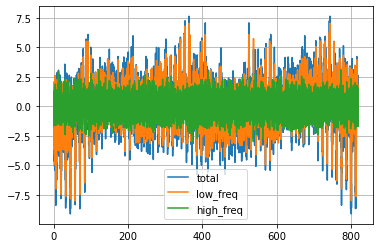

In [7]:
signal = P@m.flatten()

dct_2d = (D @ m.flatten()).reshape(nside, nside)
masked_lf = mask_lf * dct_2d
masked_hf = mask_hf * dct_2d
m_lf = (D_inv @ masked_lf.flatten()).reshape(nside, nside)
m_hf = (D_inv @ masked_hf.flatten()).reshape(nside, nside)

plt.plot(times, signal, label='total')
plt.plot(times, P @ m_lf.flatten(), label='low_freq')
plt.plot(times, P @ m_hf.flatten(), label='high_freq')
plt.legend()
plt.grid()

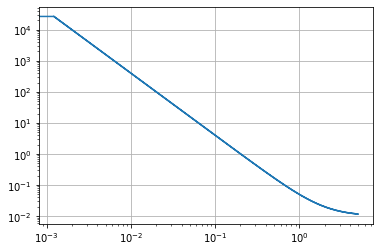

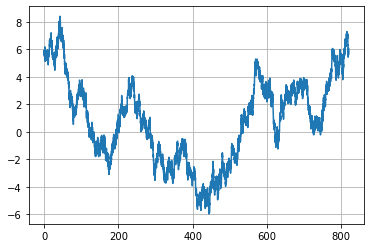

In [8]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=1e-1)
plt.plot(times, noise)
plt.grid()

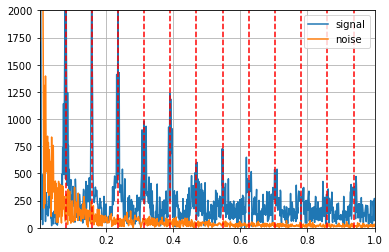

In [9]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')

for i in range(20):
    plt.axvline((i+1)/2/nside*rate, color = 'r', linestyle='dashed')

plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.ylim([0, 2000])
plt.xlim([0.001, 1])
plt.grid()

In [10]:
y = signal + noise # + n

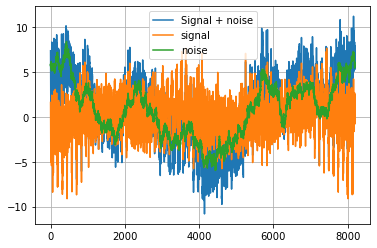

In [11]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [12]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = lib.generate_baselines(baseline_length, nsamp, rate)

In [13]:
G = P @ D_inv_hf 
Z = np.eye(nsamp) - G @ np.linalg.inv(G.T @ G) @ G.T

# assert np.abs(Z@Z - Z).max() < 1e-10

In [19]:
#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ (y )#- P @ m_lf.flatten())

print(A.shape, np.linalg.matrix_rank(A))

#NOTE, with hf, there exists a unique solution
a = np.linalg.inv(A) @ b

# a = np.linalg.solve(A, b)

# CG 
# a, error_code = cg(A, b)
# assert not error_code


(82, 82) 82


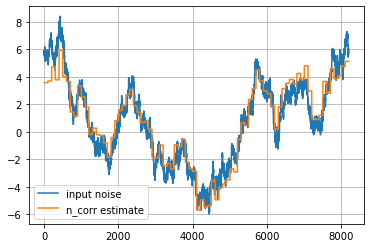

In [20]:
#Note, did not need to subtract mean
plt.plot(noise, label='input noise')
plt.plot(F @ a, label='n_corr estimate')
plt.grid()
plt.legend()

In [21]:
solver = np.linalg.inv(G.T @ G) @ G.T
m_dct_hf = solver @ (y  - F @ a )#- P @ m_lf.flatten()) 

In [22]:
#Inverse fft to get back the original map
m_solved = D_inv_hf @ m_dct_hf
m_solved = m_solved.reshape(nside, nside)

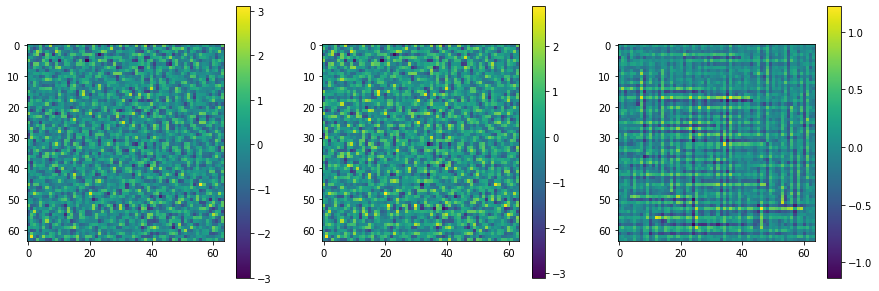

Input map std: 0.8233223600020906
Solved map std: 0.8744050760868546


In [23]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m_hf)
output_map = axes[1].imshow(m_solved)
diff_map = axes[2].imshow(m_hf - m_solved)

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m_hf)}')
print(f'Solved map std: {np.std(m_solved)}')